In [122]:
import numpy as np
import pandas as pd
from google.cloud import bigquery
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import plotly.express as px
import db_dtypes
import bigframes.pandas as bpd
from IPython.display import display, HTML
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import math
import statsmodels.api as sm
from datetime import datetime
from typing import Union
import logging
import sys


pre_holdout = """
WITH eligible_holdout_entities AS (
  SELECT
        entity_id
       ,`Release Date` as release_date
  FROM `logistics-data-storage-staging.long_term_pricing.global_holdout_rollout`
  WHERE `Release Date` < DATE_SUB(CURRENT_DATE(), INTERVAL EXTRACT(DAYOFWEEK FROM CURRENT_DATE())- 2 DAY)
),
customer_information AS (
  SELECT
         e.entity_id
        ,e.release_date
        ,customer_id
        ,is_customer_holdout
  FROM `fulfillment-dwh-production.cl.dps_holdout_users` AS d
  JOIN eligible_holdout_entities AS e
  ON d.entity_id = e.entity_id
  WHERE d.created_date >= DATE('2025-01-01')
  AND d.created_date >= e.release_date
  AND customer_id IS NOT NULL
)
SELECT 
     dps.entity_id
    ,dps.dps_customer_id
    ,ci.is_customer_holdout
    ,COUNT (DISTINCT platform_order_code) AS orders
    ,SUM(fully_loaded_gross_profit_eur) AS flgp
FROM `fulfillment-dwh-production.cl.dps_sessions_mapped_to_orders` dps
join customer_information ci on ci.entity_id = dps.entity_id and ci.customer_id = dps.dps_customer_id
WHERE created_date >= DATE('2024-10-01') and created_date <= DATE('2025-01-26')
and created_date < ci.release_date
AND platform_order_code IS NOT NULL
AND is_own_delivery
AND is_sent
AND vendor_vertical_parent in ('Restaurant','restaurant','restaurants')
GROUP BY 1,2,3

"""

post_holdout = """
WITH eligible_holdout_entities AS (
  SELECT
        entity_id
       ,`Release Date` as release_date
  FROM `logistics-data-storage-staging.long_term_pricing.global_holdout_rollout`
  WHERE `Release Date` < DATE_SUB(CURRENT_DATE(), INTERVAL EXTRACT(DAYOFWEEK FROM CURRENT_DATE())- 2 DAY)
),
customer_information AS (
  SELECT
         e.entity_id
        ,e.release_date
        ,customer_id
        ,is_customer_holdout
  FROM `fulfillment-dwh-production.cl.dps_holdout_users` AS d
  JOIN eligible_holdout_entities AS e
  ON d.entity_id = e.entity_id
  WHERE d.created_date >= DATE('2025-01-01')
  AND d.created_date >= e.release_date
  AND customer_id IS NOT NULL
)
SELECT 
     dps.entity_id
    ,dps.dps_customer_id
    ,ci.is_customer_holdout
    ,COUNT (DISTINCT platform_order_code) AS orders
    ,SUM(fully_loaded_gross_profit_eur) AS flgp
FROM `fulfillment-dwh-production.cl.dps_sessions_mapped_to_orders` dps
join customer_information ci on ci.entity_id = dps.entity_id and ci.customer_id = dps.dps_customer_id
WHERE created_date >= DATE('2025-01-01')
  AND created_date >= ci.release_date
  AND platform_order_code IS NOT NULL
  AND is_own_delivery
  AND is_sent
  AND vendor_vertical_parent in ('Restaurant','restaurant','restaurants')
GROUP BY 1,2,3
"""


grouped = """
WITH eligible_holdout_entities AS (
  SELECT
        entity_id
       ,`Release Date` as release_date
  FROM `logistics-data-storage-staging.long_term_pricing.global_holdout_rollout`
  WHERE `Release Date` < DATE_SUB(CURRENT_DATE(), INTERVAL EXTRACT(DAYOFWEEK FROM CURRENT_DATE())- 2 DAY)
),
customer_information AS (
  SELECT
         e.entity_id
        ,e.release_date
        ,is_customer_holdout
        ,count(distinct customer_id) users
  FROM `fulfillment-dwh-production.cl.dps_holdout_users` AS d
  JOIN eligible_holdout_entities AS e
  ON d.entity_id = e.entity_id
  WHERE d.created_date >= DATE('2025-01-01')
  AND d.created_date >= e.release_date
  AND customer_id IS NOT NULL
  group by 1,2,3
)
SELECT 
     dps.entity_id
    ,dps.is_customer_holdout
    ,users
    ,COUNT (DISTINCT platform_order_code) AS orders
    ,SUM(fully_loaded_gross_profit_eur) AS flgp
    ,sum(profit_eur) profit_eur
    ,sum(revenue_eur) revenue_eur
    ,sum(gfv_eur) gfv_eur
    ,sum(delivery_costs_eur) delivery_cost
    ,sum(discount_dh_eur) discount_dh_eur
    ,sum(dps_delivery_fee_eur) dps_delivery_fee_eur
    ,COUNT (DISTINCT platform_order_code) / users opu
    ,SUM(fully_loaded_gross_profit_eur) / COUNT (DISTINCT platform_order_code) flgpo
    ,sum(profit_eur) / COUNT (DISTINCT platform_order_code) profit_per_order
    ,sum(revenue_eur) / COUNT (DISTINCT platform_order_code) revenue_per_order
    ,sum(delivery_costs_eur) / COUNT (DISTINCT platform_order_code) delivery_cost_per_order
    ,sum(gfv_eur) / COUNT (DISTINCT platform_order_code) gfv_eur_per_order
    ,sum(discount_dh_eur) / COUNT (DISTINCT platform_order_code) discount_per_order
    ,sum(dps_delivery_fee_eur) / COUNT (DISTINCT platform_order_code) delivery_fee_per_order
FROM `fulfillment-dwh-production.cl.dps_sessions_mapped_to_orders` dps
left join customer_information ci on ci.entity_id = dps.entity_id and ci.is_customer_holdout = dps.is_customer_holdout
WHERE created_date >= DATE('2025-01-01')
AND created_date >= ci.release_date
AND platform_order_code IS NOT NULL
AND is_own_delivery
AND is_sent
AND vendor_vertical_parent in ('Restaurant','restaurant','restaurants')
GROUP BY 1,2,3

"""

In [126]:
# define a few things (project id, start date etc.)
project_id = "logistics-customer-staging"
client = bigquery.Client(project = project_id)

pre_holdout = client.query(pre_holdout).to_dataframe()
#post_holdout = client.query(post_holdout).to_dataframe()
grouped_df = client.query(grouped).to_dataframe()

/Users/shazeb.asad/global_pricing/.venv/lib/python3.12/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [222]:
final_df = pd.DataFrame()

comparison_df = grouped_df[['entity_id','is_customer_holdout','opu','flgpo','profit_per_order','revenue_per_order','delivery_cost_per_order','gfv_eur_per_order','discount_per_order','delivery_fee_per_order']]

# Create a list to store transformed DataFrames
df_list = []

for i in comparison_df['entity_id'].unique():
    tmp = comparison_df[comparison_df['entity_id'] == i]
    tmp = tmp[['is_customer_holdout','opu','flgpo','profit_per_order','revenue_per_order','delivery_cost_per_order','gfv_eur_per_order','discount_per_order','delivery_fee_per_order']]
    
    # Set index and transpose
    tmp = tmp.set_index('is_customer_holdout').transpose()
    tmp['entity'] = i

    # Store in list
    df_list.append(tmp)

# Concatenate all DataFrames in the list
final_df = pd.concat(df_list)

# Reset index if needed
final_df.reset_index(inplace=True)

final_df = final_df.rename(columns={
    'level_0': '',
    'index': 'metrics',
    True: 'holdout_true',
    False: 'holdout_false',
})

final_df[['holdout_true','holdout_false']] = final_df[['holdout_true','holdout_false']].astype(float)

# Prevent division by zero by replacing zero values with NaN (to avoid infinite values)
final_df["perc_diff"] = 100 * abs(
    (final_df["holdout_false"] - final_df["holdout_true"]) / final_df["holdout_true"].replace(0, float("nan"))
)

# Replace NaN values with 0 (or another desired value)
final_df["perc_diff"].fillna(0, inplace=True)

/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_50013/350284581.py:40: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  final_df["perc_diff"].fillna(0, inplace=True)


In [224]:
# Export the merged DataFrame as a CSV file
csv_filename = "holdout_non_holdout_details.csv"
final_df.to_csv(csv_filename, index=False)

In [201]:
# discount mismatch
entities_discount = final_df.loc[
    (final_df["metrics"] == "discount_per_order") & (final_df["perc_diff"] > 2), 
    ["entity", "perc_diff"]
]
entities_discount_df = pd.DataFrame(entities_discount)
entities_discount_df["discount_per_order_mismatch?"] = "Yes"
entities_discount_df = entities_discount_df.rename(columns={"perc_diff": "discount_perc_diff"})

# delivery fee mismatch
entities_delivery_fee = final_df.loc[
    (final_df["metrics"] == "delivery_fee_per_order") & (final_df["perc_diff"] > 5), 
    ["entity", "perc_diff"]
]
entities_delivery_fee_df = pd.DataFrame(entities_delivery_fee)
entities_delivery_fee_df["delivery_fee_per_order_mismatch?"] = "Yes"
entities_delivery_fee_df = entities_delivery_fee_df.rename(columns={"perc_diff": "delivery_fee_perc_diff"})

# opu mismatch
entities_opu = final_df.loc[
    (final_df["metrics"] == "opu") & (final_df["perc_diff"] > 5), 
    ["entity", "perc_diff"]
]
entities_opu_df = pd.DataFrame(entities_opu)
entities_opu_df["opu_mismatch?"] = "Yes"
entities_opu_df = entities_opu_df.rename(columns={"perc_diff": "opu_perc_diff"})

# entities_discount = final_df.loc[
#     (final_df["metrics"] == "discount_per_order") & (final_df["perc_diff"] > 2), 
#     ["entity", "perc_diff"]
# ]
# entities_discount_df = pd.DataFrame(entities_discount)
# entities_opu_df["opu_mismatch"] = "Yes"

# # Step 2: Find intersection (entities that meet both conditions)
# valid_entities = list(entities_discount & entities_delivery_fee)

# # Display result
# len(valid_entities)

In [216]:
# Group by holdout and non-holdout groups
group_metrics = pre_holdout.groupby(['entity_id','is_customer_holdout']).agg({'orders':'mean'}).reset_index()

# Create a list to store transformed DataFrames
df_list = []

for i in group_metrics['entity_id'].unique():
    tmp = group_metrics[group_metrics['entity_id'] == i]
    tmp = tmp[['is_customer_holdout','orders']]
    
    # Set index and transpose
    tmp = tmp.set_index('is_customer_holdout').transpose()
    tmp['entity'] = i

    # Store in list
    df_list.append(tmp)

# Concatenate all DataFrames in the list
final_df = pd.concat(df_list)

# Reset index if needed
final_df.reset_index(inplace=True)

final_df = final_df.rename(columns={
    'level_0': '',
    'index': 'metrics',
    True: 'holdout_true',
    False: 'holdout_false',
})

final_df[['holdout_true','holdout_false']] = final_df[['holdout_true','holdout_false']].astype(float)

# Prevent division by zero by replacing zero values with NaN (to avoid infinite values)
final_df["perc_diff"] = 100 * abs(
    (final_df["holdout_false"] - final_df["holdout_true"]) / final_df["holdout_true"].replace(0, float("nan"))
)

# Replace NaN values with 0 (or another desired value)
final_df["perc_diff"].fillna(0, inplace=True)

final_df

# discount mismatch
entities_pre_holdout = final_df.loc[
    (final_df["metrics"] == "orders") & (final_df["perc_diff"] > 5), 
    ["entity", "perc_diff"]
]
entities_pre_holdout_df = pd.DataFrame(entities_pre_holdout)
entities_pre_holdout_df["pre_holdout_oou_mismatch?"] = "Yes"
entities_pre_holdout_df = entities_pre_holdout_df.rename(columns={"perc_diff": "pre_holdout_orders_per_user_diff"})

entities_pre_holdout_df

/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_50013/3187617128.py:39: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  final_df["perc_diff"].fillna(0, inplace=True)


is_customer_holdout,entity,pre_holdout_orders_per_user_diff,pre_holdout_oou_mismatch?
19,GV_ME,5.779630,Yes
20,GV_NG,10.046522,Yes
25,HS_SA,43.962106,Yes


In [218]:
# Extract unique entities
issue_df = final_df[['entity']].drop_duplicates()

# List of DataFrames to merge (replace df1, df2, df3 with actual DataFrames)
dataframes = [entities_discount_df, entities_delivery_fee_df, entities_opu_df, entities_pre_holdout_df]  # Example list of DataFrames

# Merge all DataFrames sequentially with 'a' on 'entity'
merged_df = issue_df.copy()
for df in dataframes:
    merged_df = merged_df.merge(df, on="entity", how="left")  # Use 'left' join to keep all entities

In [221]:
# Export the merged DataFrame as a CSV file
csv_filename = "holdout_mismatch.csv"
merged_df.to_csv(csv_filename, index=False)

Descriptive Statistics:
                         count      mean        std  min  25%  50%  75%    max
is_customer_holdout                                                          
False                650841.0  8.367704  16.058368  1.0  1.0  3.0  8.0  858.0
True                  12894.0  8.377307  15.315234  1.0  1.0  3.0  8.0  183.0
T-test Results:
T-Statistic: 0.06730113413239348, P-Value: 0.9463419943023771


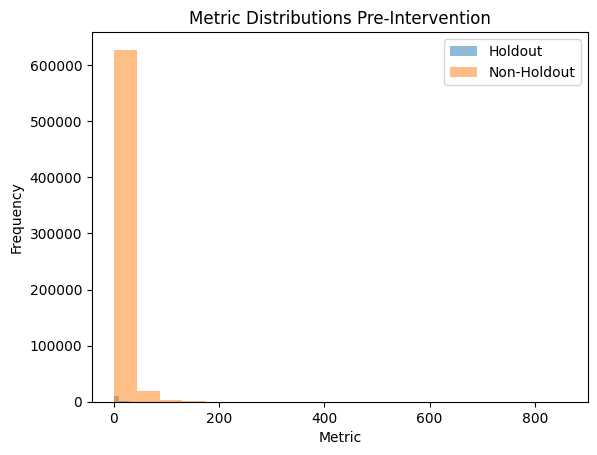

In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

SG_pre = pre_holdout[pre_holdout['entity_id'] == 'FP_TH']

pre_intervention_df =  SG_pre.copy()

# Filter pre-intervention data
#pre_intervention_df = df[df['release_date'] < 'intervention_date']

# Group by holdout and non-holdout groups
group_metrics = pre_intervention_df.groupby('is_customer_holdout')['orders']

# Descriptive statistics
group_stats = group_metrics.describe()
print("Descriptive Statistics:\n", group_stats)

# T-test to compare means
holdout_metrics = pre_intervention_df[pre_intervention_df['is_customer_holdout'] == True]['orders']
non_holdout_metrics = pre_intervention_df[pre_intervention_df['is_customer_holdout'] == False]['orders']

t_stat, p_value = ttest_ind(holdout_metrics, non_holdout_metrics)
print(f"T-test Results:\nT-Statistic: {t_stat}, P-Value: {p_value}")

# Visualizing distributions
plt.hist(holdout_metrics, bins=20, alpha=0.5, label='Holdout')
plt.hist(non_holdout_metrics, bins=20, alpha=0.5, label='Non-Holdout')
plt.xlabel('Metric')
plt.ylabel('Frequency')
plt.legend()
plt.title('Metric Distributions Pre-Intervention')
plt.show()

In [128]:
post_holdout

"\nWITH eligible_holdout_entities AS (\n  SELECT\n        entity_id\n       ,`Release Date` as release_date\n  FROM `logistics-data-storage-staging.long_term_pricing.global_holdout_rollout`\n  WHERE `Release Date` < DATE_SUB(CURRENT_DATE(), INTERVAL EXTRACT(DAYOFWEEK FROM CURRENT_DATE())- 2 DAY)\n),\ncustomer_information AS (\n  SELECT\n         e.entity_id\n        ,e.release_date\n        ,customer_id\n        ,is_customer_holdout\n  FROM `fulfillment-dwh-production.cl.dps_holdout_users` AS d\n  JOIN eligible_holdout_entities AS e\n  ON d.entity_id = e.entity_id\n  WHERE d.created_date >= DATE('2025-01-01')\n  AND d.created_date >= e.release_date\n  AND customer_id IS NOT NULL\n)\nSELECT \n     dps.entity_id\n    ,dps.dps_customer_id\n    ,ci.is_customer_holdout\n    ,COUNT (DISTINCT platform_order_code) AS orders\n    ,SUM(fully_loaded_gross_profit_eur) AS flgp\nFROM `fulfillment-dwh-production.cl.dps_sessions_mapped_to_orders` dps\njoin customer_information ci on ci.entity_id = dps

In [127]:
SG_post = post_holdout[post_holdout['entity_id'] == 'FP_SG']

post_intervention_df =  SG_post.copy()

# Filter pre-intervention data
#post_intervention_df = df[df['time_period'] < 'intervention_date']

# Group by holdout and non-holdout groups
group_metrics = post_intervention_df.groupby('is_customer_holdout')['flgp']

# Descriptive statistics
group_stats = group_metrics.describe()
print("Descriptive Statistics:\n", group_stats)

# T-test to compare means
holdout_metrics = post_intervention_df[post_intervention_df['is_customer_holdout'] == True]['flgp']
non_holdout_metrics = post_intervention_df[post_intervention_df['is_customer_holdout'] == False]['flgp']

t_stat, p_value = ttest_ind(holdout_metrics, non_holdout_metrics)
print(f"T-test Results:\nT-Statistic: {t_stat}, P-Value: {p_value}")

# Visualizing distributions
plt.hist(holdout_metrics, bins=20, alpha=0.5, label='Holdout')
plt.hist(non_holdout_metrics, bins=20, alpha=0.5, label='Non-Holdout')
plt.xlabel('Metric')
plt.ylabel('Frequency')
plt.legend()
plt.title('Metric Distributions Pre-Intervention')
plt.show()

TypeError: string indices must be integers, not 'str'